# Language Identification

[Language identification](https://en.wikipedia.org/wiki/Language_identification) is one of the most common feature of every Social Network or Web application, this is commonly paired with [Machine Translation](https://en.wikipedia.org/wiki/Machine_translation) to improve the user experience and content accesibility(a must have in the 2.0 society). The goal of the task  is to detect the natural language of a given piece of text. *What can you use it for?* This is a foundation for other features such as Machine Translation (as mentioned before) and post/tweets/articles and documents analysis.

### Language identification of short pieces of text from Wikipedia

In this notebook we will build a deep learning model able to [detect the languages from short piceces of text (140 characters, old Tweets lenght) with high accuracy using neural networks](http://machinelearningexp.com/deep-learning-language-identification-using-keras-tensorflow/). The task is commonly solved using hard-coded rules or NLP library, but we will attack the problem using Deep Learning. 

<img src="https://raw.githubusercontent.com/floydhub/language-identification-template/master/images/fhchat.png" width="500" height="500" align="center"/>

*Made with [Sketch Group Chat](https://www.sketchappsources.com/free-source/1558-group-chat-sketch-freebie-resource.html)*

We have [already gathered and extract the raw dataset](https://floydhub.com/floydhub/datasets/language-identification/1) from https://dumps.wikimedia.org for 7 languages: *Italian*, *Spanish* and *French* which are considered to be in Latin language group, *English* and *German* have also common roots. *Czech* and *Slovakian* are extremely similar and are considered to be one of major challenged in the language recognition.

iso-code | language | example
---------|----------|--------
en | English | Hello world!
fr | French | Bonjour tout le monde!
es | Spanish | Hola mundo!
it | Italian | Ciao mondo!
de | German | Hallo welt!
cz | Czech | Ahoj světe!
sk | Slovakian | Dobrý deň svet!

We will:

- Preprocess text data for NLP
- Build and train Deep Neural Network using Keras and Tensorflow
- Evaluate our model on the test set
- Run the model on your own text!


### Instructions
- To execute a code cell, click on the cell and press `Shift + Enter` (shortcut for Run).
- To learn more about Workspaces, check out the [Getting Started Notebook](get_started_workspace.ipynb).
- **Tip**: *Feel free to try this Notebook with your own data and on your own super awesome regression task.*

Now, let's get started! 🚀

## Initial Setup
Let's start by importing some packages.

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import time

from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras.optimizers

Using TensorFlow backend.


## Training Parameters

We'll set the hyperparameters for training our model. If you understand what they mean, feel free to play around - otherwise, we recommend keeping the defaults for your first run 🙂

In [2]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 512  # Number of images used in each iteration
    EPOCHS = 12  # Number of passes through entire dataset
    
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 64
    EPOCHS = 12

## Data preparation

*WARNING*

Make sure that the dataset has been mounted before running the next Code Cells. The data mounting should take about 3 minutes.

In [3]:
#################
# Configuration #
#################

# dictionary of languages that our classifier will cover
LANGUAGES_DICT = {'en':0,'fr':1,'es':2,'it':3,'de':4,'sk':5,'cs':6}

# Length of cleaned text used for training and prediction - 140 chars
MAX_LEN = 140

# number of language samples per language that we will extract from source files
NUM_SAMPLES = 250000

# For reproducibility
SEED = 42

from support import define_alphabet
# Load the Alphabet
alphabet = define_alphabet()
print('ALPHABET:')
print(alphabet[2])

VOCAB_SIZE = len(alphabet[2])
print('ALPHABET LEN(VOCAB SIZE):', VOCAB_SIZE)

# Folders from where load / store the raw, source, cleaned, samples and train_test data
data_directory = "/floyd/input/languageidentification/data"
source_directory = os.path.join(data_directory, 'source')
cleaned_directory = os.path.join(data_directory, 'cleaned')
samples_directory = os.path.join('/tmp', 'samples')
train_test_directory = os.path.join('/tmp', 'train_test')

ALPHABET:
abcdefghijklmnopqrstuvwxyzßàáâäæçèéêìíîïñòóôöùúûüýÿčďěĺľňœŕřšťůž !?¿¡ABCDEFGHIJKLMNOPQRSTUVWXYZÀÁÂÄÆÇÈÉÊÌÍÎÏÑÒÓÔÖÙÚÛÜÝČĎĚĹĽŇŒŔŘŠŤŮŸŽ
ALPHABET LEN(VOCAB SIZE): 132


Before feeding the data into the model, we have to preprocess the text.

We will use the characters frequency as features to our model. This representation is similar to the [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) model, with the exception that we are using characters and not words for defining the Vocabulary. You can see an example below:

In [4]:
from support import get_sample_text, get_input_row
    
# let's see if our processing is returning counts
# last part calculates also input_size for DNN so this code must be run before DNN is trained
path = os.path.join(cleaned_directory, "de_cleaned.txt")
with open(path, 'r') as f:
    content = f.read()
    random_index = random.randrange(0,len(content)-2*MAX_LEN)
    sample_text = get_sample_text(content,random_index,MAX_LEN)
    print ("1. SAMPLE TEXT: \n", sample_text)
    print ("\n2. REFERENCE ALPHABET: \n", alphabet[0]+alphabet[1])
    
    sample_input_row = get_input_row(content, random_index, MAX_LEN, alphabet)
    print ("\n3. SAMPLE INPUT ROW: \n",sample_input_row)
    
    input_size = len(sample_input_row)
    if input_size != VOCAB_SIZE:
        print("Something strange happened!")
        
    print ("\n4. INPUT SIZE (VOCAB SIZE): ", input_size)
    del content

1. SAMPLE TEXT: 
 die Fähre "Ibn Batouta", und den Mondkrater Ibn Battuta. Liste der Gemeinden in Österreich Dies ist eine Zusammenstellung von Listen der

2. REFERENCE ALPHABET: 
 ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ß', 'à', 'á', 'â', 'ä', 'æ', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'î', 'ï', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ù', 'ú', 'û', 'ü', 'ý', 'ÿ', 'č', 'ď', 'ě', 'ĺ', 'ľ', 'ň', 'œ', 'ŕ', 'ř', 'š', 'ť', 'ů', 'ž', ' ', '!', '?', '¿', '¡', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'À', 'Á', 'Â', 'Ä', 'Æ', 'Ç', 'È', 'É', 'Ê', 'Ì', 'Í', 'Î', 'Ï', 'Ñ', 'Ò', 'Ó', 'Ô', 'Ö', 'Ù', 'Ú', 'Û', 'Ü', 'Ý', 'Č', 'Ď', 'Ě', 'Ĺ', 'Ľ', 'Ň', 'Œ', 'Ŕ', 'Ř', 'Š', 'Ť', 'Ů', 'Ÿ', 'Ž']

3. SAMPLE INPUT ROW: 
 [6, 4, 1, 8, 18, 1, 2, 2, 11, 0, 1, 4, 4, 13, 3, 0, 0, 7, 7, 11, 5, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Now we will apply the transformation from raw text to Bag of Characters representation for all the data we have collected. At the end of the proprocessing, we will have 250k samples per language where every sample will be piece of text 140 characters long, represented using the Bag of Characters model.

Dataset dimension (1750k, 133):
- rows: 1750k (250k * 7) or (NUM_SAMPLES * num_languages)
- columns: 133 (132 + 1) or (VOCAB_SIZE + language_index)

In [5]:
# Utility function to return file Bytes size in MB
def size_mb(size):
    size_mb =  '{:.2f}'.format(size/(1000*1000.0))
    return size_mb + " MB"

# Now we have preprocessing utility functions ready. Let's use them to process each cleaned language file
# and turn text data into numerical data samples for our neural network
# prepare numpy array
sample_data = np.empty((NUM_SAMPLES*len(LANGUAGES_DICT),input_size+1),dtype = np.uint16)
lang_seq = 0 # offset for each language data
jump_reduce = 0.2 # part of characters removed from jump to avoid passing the end of file

for lang_code in LANGUAGES_DICT:
    start_index = 0
    path = os.path.join(cleaned_directory, lang_code+"_cleaned.txt")
    with open(path, 'r') as f:
        print ("Processing file : " + path)
        file_content = f.read()
        content_length = len(file_content)
        remaining = content_length - MAX_LEN*NUM_SAMPLES
        jump = int(((remaining/NUM_SAMPLES)*3)/4)
        print ("File size : ",size_mb(content_length),\
               " | # possible samples : ",int(content_length/VOCAB_SIZE),\
              "| # skip chars : " + str(jump))
        for idx in range(NUM_SAMPLES):
            input_row = get_input_row(file_content, start_index, MAX_LEN, alphabet)
            sample_data[NUM_SAMPLES*lang_seq+idx,] = input_row + [LANGUAGES_DICT[lang_code]]
            start_index += MAX_LEN + jump
        del file_content
    lang_seq += 1
    print (100*"-")
     
# Let's randomy shuffle the data
np.random.shuffle(sample_data)
# reference input size
print ("Vocab Size : ",VOCAB_SIZE )
print (100*"-")
print ("Samples array size : ",sample_data.shape )

# Create the the sample dirctory if not exists
if not os.path.exists(samples_directory):
    os.makedirs(samples_directory)

# Save compressed sample data to disk
path_smpl = os.path.join(samples_directory,"lang_samples_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_smpl,data=sample_data)
print(path_smpl, "size : ", size_mb(os.path.getsize(path_smpl)))
del sample_data

Processing file : /floyd/input/languageidentification/data/cleaned/en_cleaned.txt
File size :  101.42 MB  | # possible samples :  768340 | # skip chars : 199
----------------------------------------------------------------------------------------------------
Processing file : /floyd/input/languageidentification/data/cleaned/fr_cleaned.txt
File size :  98.72 MB  | # possible samples :  747899 | # skip chars : 191
----------------------------------------------------------------------------------------------------
Processing file : /floyd/input/languageidentification/data/cleaned/es_cleaned.txt
File size :  97.56 MB  | # possible samples :  739111 | # skip chars : 187
----------------------------------------------------------------------------------------------------
Processing file : /floyd/input/languageidentification/data/cleaned/it_cleaned.txt
File size :  101.89 MB  | # possible samples :  771891 | # skip chars : 200
-------------------------------------------------------------------

Sanity check.

In [6]:
# utility function to turn language id into language code
def decode_langid(langid):    
    for dname, did in LANGUAGES_DICT.items():
        if did == langid:
            return dname

# Loading the data
path_smpl = os.path.join(samples_directory,"lang_samples_"+str(VOCAB_SIZE)+".npz")
dt = np.load(path_smpl)['data']

# Sanity chech on a random sample
random_index = random.randrange(0,dt.shape[0])
print ("Sample record : \n",dt[random_index,])
print ("\nSample language : ",decode_langid(dt[random_index,][VOCAB_SIZE]))

# Check if the data have equal share of different languages
print ("\nDataset shape (Total_samples, Alphabet):", dt.shape)
bins = np.bincount(dt[:,input_size])

print ("Language bins count (samples per language): ") 
for lang_code in LANGUAGES_DICT: 
    print (lang_code, bins[LANGUAGES_DICT[lang_code]])

Sample record : 
 [10  2  3  6 13  4  4  2 10  0  0  8  3  6  5  3  0  4 10  6  4  0  0  1
  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 18  0  0  0  0  0  0  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0]

Sample language :  en

Dataset shape (Total_samples, Alphabet): (1750000, 133)
Language bins count (samples per language): 
en 250000
fr 250000
es 250000
it 250000
de 250000
sk 250000
cs 250000


### Data preprocessing

Even if our data is ready for the training, we have to [Standardize](https://en.wikipedia.org/wiki/Feature_scaling#Standardization) the dataset. This will help our model to converge faster since it makes the data more "computational friendly".

In [7]:
# we need to preprocess data for DNN yet again - scale it 
# scaling will ensure that our optimization algorithm (variation of gradient descent) will converge well
# we need also ensure one-hot econding of target classes for softmax output layer
# let's convert datatype before processing to float
dt = dt.astype(np.float32)
# X and Y split
X = dt[:, 0:input_size] # Samples
Y = dt[:, input_size] # The last element is the label
del dt

# Random index to check random sample
random_index = random.randrange(0,X.shape[0])
print("Example data before processing:")
print("X : \n", X[random_index,])
print("Y : \n", Y[random_index])

# X PREPROCESSING
# Feature Standardization - Standar scaler will be useful later during DNN prediction
standard_scaler = preprocessing.StandardScaler().fit(X)
X = standard_scaler.transform(X)   
print ("X preprocessed shape :", X.shape)

# Y PREPROCESSINGY 
# One-hot encoding
Y = keras.utils.to_categorical(Y, num_classes=len(LANGUAGES_DICT))

# See the sample data
print("\nExample data after processing:")
print("X : \n", X[random_index,])
print("Y : \n", Y[random_index])

# Train/test split. Static seed to have comparable results for different runs
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED)
del X, Y

# Create the train / test directory if not extists
if not os.path.exists(train_test_directory):
    os.makedirs(train_test_directory)

# Save compressed train_test data to disk
path_tt = os.path.join(train_test_directory,"train_test_data_"+str(VOCAB_SIZE)+".npz")
np.savez_compressed(path_tt,X_train=X_train,Y_train=Y_train,X_test=X_test,Y_test=Y_test)
print(path_tt, "size : ",size_mb(os.path.getsize(path_tt)))
del X_train,Y_train,X_test,Y_test

Example data before processing:
X : 
 [ 8.  0.  5.  5. 21.  2.  1.  7.  6.  0.  0.  6.  1.  8.  5.  0.  0.  7.
 10. 10.  4.  3.  2.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 24.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
Y : 
 0.0
X preprocessed shape : (1750000, 132)

Example data after processing:
X : 
 [-4.17050153e-01 -1.13270748e+00  6.38392270e-01  1.75331384e-01
  1.73380041e+00  5.33405364e-01 -3.80145878e-01  1.91697395e+00
 -5.14976740e-01 -6.19032502e-01 -7.30089128e-01  1.92491740e-01
 -1.09850657e+00 -2.04314422e-02 -7.94259489e-01 -1.46870685e+00
 -4.61331427e-01  5.33611178e-02  1.16716337e+00  1.14771831e+00
  3.73478569e-

## Train - Test Split

Split: 80% for Train and 20% for Test

In [8]:
# Load train data first from file
path_tt = os.path.join(train_test_directory, "train_test_data_"+str(VOCAB_SIZE)+".npz")
train_test_data = np.load(path_tt)

# Train Set
X_train = train_test_data['X_train']
print ("X_train: ",X_train.shape)
Y_train = train_test_data['Y_train']
print ("Y_train: ",Y_train.shape)

# Test Set
X_test = train_test_data['X_test']
print ("X_test: ",X_test.shape)
Y_test = train_test_data['Y_test']
print ("Y_test: ",Y_test.shape)

del train_test_data

X_train:  (1400000, 132)
Y_train:  (1400000, 7)
X_test:  (350000, 132)
Y_test:  (350000, 7)


### Model

We will implement a really simple 3 layers Neural Network with [Droput](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) for preventing Overfitting. We will also use the [Xavier initializer](https://www.quora.com/What-is-an-intuitive-explanation-of-the-Xavier-Initialization-for-Deep-Neural-Networks)(one of the best initialization scheme, this will improve the chance to converge in a better "place": a point with better accuracy).

![nn](http://neuralnetworksanddeeplearning.com/images/tikz40.png)

*From http://neuralnetworksanddeeplearning.com/*

In [9]:
model = Sequential()
# Note: glorot_uniform is the Xavier uniform initializer.

model.add(Dense(500,input_dim=input_size, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(300, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(100, kernel_initializer="glorot_uniform", activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(len(LANGUAGES_DICT), kernel_initializer="glorot_uniform", activation="softmax"))
model_optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=model_optimizer,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               66500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               150300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 707       
Total para

### Train & Evaluate

If you left the default hyperpameters in the Notebook untouched, your training should take approximately:

- On CPU machine: 24 minutes for 12 epochs.
- On GPU machine: 3 minute for 12 epochs.

*Note*: You can follow the execution on Tensorboard.

In [ ]:
from keras.callbacks import TensorBoard

# Tensorboard
tensorboard = TensorBoard(log_dir="run")

# let's fit the data
# history variable will help us to plot results later
history = model.fit(X_train,Y_train,
                  epochs=EPOCHS,
                  validation_split=0.1,
                  batch_size=BATCH_SIZE,
                  callbacks=[tensorboard],
                  shuffle=True,
                  verbose=2)

In [11]:
# Evaluation on Test set
scores = model.evaluate(X_test, Y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

350000/350000 [==============================] - 15s 42us/step
acc: 97.60%


In [12]:
# and now we will prepare data for scikit-learn confusion matrix and classification report
Y_pred = model.predict_classes(X_test)
Y_pred = keras.utils.to_categorical(Y_pred, num_classes=len(LANGUAGES_DICT))
LABELS =  list(LANGUAGES_DICT.keys())

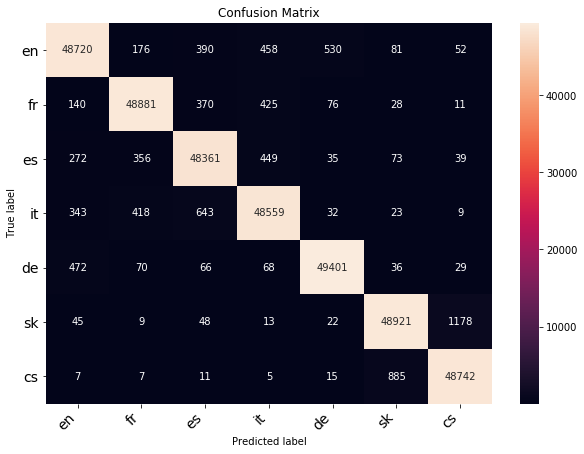

In [13]:
# Plot confusion matrix 
from sklearn.metrics import confusion_matrix
from support import print_confusion_matrix

cnf_matrix = confusion_matrix(np.argmax(Y_pred,axis=1), np.argmax(Y_test,axis=1))
_ = print_confusion_matrix(cnf_matrix, LABELS)

In [14]:
# Classification Report
print(classification_report(Y_test, Y_pred, target_names=LABELS))

             precision    recall  f1-score   support

         en       0.97      0.97      0.97     49999
         fr       0.98      0.98      0.98     49917
         es       0.98      0.97      0.97     49889
         it       0.97      0.97      0.97     49977
         de       0.99      0.99      0.99     50111
         sk       0.97      0.98      0.98     50047
         cs       0.98      0.97      0.98     50060

avg / total       0.98      0.98      0.98    350000



## It's your turn

Test out the model you just trained. Run the code Cell below and type your text in the widget, Have fun!🎉

Here are some inspirations:

##### EN - Frank Baum, The Wonderful Wizard of Oz, Project Gutenberg, public domain
You are welcome, most noble Sorceress, to the land of the Munchkins. We are so grateful to you for having killed the Wicked Witch of the East, and for setting our people free from bondage.

##### DE - Johann Wolfgang von Goethe, Faust: Der Tragödie erster Teil, Project Gutenberg, public domain
Habe nun, ach! Philosophie, Juristerei und Medizin, Und leider auch Theologie  Durchaus studiert, mit heißem Bemühn. Da steh ich nun, ich armer Tor! Und bin so klug als wie zuvor.

##### FR - Pierre Benoît, L'Atlantide, 
Voilà cinq mois que j'en faisais fonction, et, ma foi, je supportais bien cette responsabilité et goûtais fort cette indépendance. Je puis même affirmer, sans me flatter.

##### IT - Alberto Boccardi, Il peccato di Loreta, Project Gutenberg, public domain
Giovanni Sant'Angelo, che negli anni passati a Padova in mezzo alla baraonda tanto gioconda degli studenti, aveva appreso ad amare con foga di giovane qualche alto ideale, tornato in famiglia dovette fare uno sforzo.

##### ES - Fernando Callejo Ferrer, Música y Músicos Portorriqueños, Project Gutenberg, public domain
Dedicada esta sección a la reseña de los compositores nativos y obras que han producido, con ligeros comentarios propios a cada uno, parécenos oportuno dar ligeras noticias sobre el origen de la composición.

##### CS - František Omelka, Blesky nad Beskydami, Project Gutenberg, public domain
A Slávek, jsa povzbuzen, se ptal a otec odpovídal. Přestože byl prostým venkovským listonošem, nepřivedla jej žádná synova otázka do rozpaků. Od mládí se zajímal o dějepis a literaturu.

##### SK - Janko Matúška, Nad Tatrou sa blýska,  national anthem of Slovakia, https://en.wikipedia.org/wiki/Nad_Tatrou_sa_blýska
Nad Tatrou sa blýska Hromy divo bijú Zastavme ich, bratia Veď sa ony stratia Slováci ožijú To Slovensko naše Posiaľ tvrdo spalo Ale blesky hromu Vzbudzujú ho k tomu Aby sa prebralo.

Can you do better? Play around with the model hyperparameters!

In [15]:
# and now we will have some fun. Seeing is believing!
# We will take some texts and try to predict the text's language using our trained neural network.

from ipywidgets import interact_manual
from ipywidgets import widgets
from support import clean_text


def get_prediction(TEXT):
    if len(TEXT) < MAX_LEN:
        print("Text has to be at least {} chars long, but it is {}/{}".format(MAX_LEN, len(TEXT), MAX_LEN))
        return(-1)
    # Data cleaning
    cleaned_text = clean_text(TEXT)
    
    # Get the MAX_LEN char
    input_row = get_input_row(cleaned_text, 0, MAX_LEN, alphabet)
    
    # Data preprocessing (Standardization)
    test_array = standard_scaler.transform([input_row])
    
    raw_score = model.predict(test_array)
    pred_idx= np.argmax(raw_score, axis=1)[0]
    score = raw_score[0][pred_idx]*100
    
    # Prediction
    prediction = LABELS[model.predict_classes(test_array)[0]]
    print('TEXT:', TEXT, '\nPREDICTION:', prediction.upper(), '\nSCORE:', score)

interact_manual(get_prediction, TEXT=widgets.Textarea(placeholder='Type the text to identify here'));

interactive(children=(Textarea(value='', description='TEXT', placeholder='Type the text to identify here'), Bu…

## Save your model

In [16]:
# Saving Model Weight
model.save_weights('models/lang_identification_weights.h5')

##### That's all folks - don't forget to shutdown your workspace once you're done 🙂